Author: Emily Wong \
April 23, 2024

# 1. Import libraries, methods, and data

## 1.1. Libraries

In [21]:
import warnings
warnings.filterwarnings('ignore')

# Data wrangling
import pandas as pd
import numpy as np
from numpy.random import uniform, normal, seed

# Machine learning
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_val_score
import scipy
from scipy.stats import randint
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
import optuna
import joblib

# Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns # for kernel density plots

# for nested dictionary (calc_weights method)
import collections
def makehash():
    return collections.defaultdict(makehash)

# Fairness
import aif360
import fairlearn
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio, false_negative_rate

## 1.2 Reweighing Method

In [23]:
def calc_weights(df, sens_features_name, outcome_name):
    ''' Calculate sample weights according to calculationg given in 
           F. Kamiran and T. Calders,  "Data Preprocessing Techniques for
           Classification without Discrimination," Knowledge and Information
           Systems, 2012.
    ''' 
    
    # combination of label and groups (outputs a table)
    sens_features = df[sens_features_name]
    outcome = df[outcome_name]
    tab = pd.DataFrame(pd.crosstab(index=sens_features, columns=outcome))

    # reweighing weights
    w = makehash()
    n = len(df)
    for r in tab.index:
        key1 = str(r)
        row_sum = tab.loc[r].sum(axis=0)
        for c in tab.columns:
            key2 = str(c)
            col_sum = tab[c].sum()
            if tab.loc[r,c] == 0:
                n_combo = 1
            else:
                n_combo = tab.loc[r,c]
            val = (row_sum*col_sum)/(n*n_combo)
            w[key1][key2] = val
    
    # Instance weights
    instance_weights = []
    for index, row in df.iterrows():
        race = row[sens_features_name]
        out = row[outcome_name]
        instance_weights.append(w[race][str(out)])

    return instance_weights

In [24]:
def model_eval(model, model_label, X_train, Y_train, X_test, Y_test, outcome_label, W=None, verbose=False):
    results = []
    o = outcome_label
    
    # Fit model
    if W is None:
        model.fit(X_train,Y_train)
    else:
        model.fit(X_train,Y_train, sample_weight=W)
    
    # Model predictions on test
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    # Test performance metrics
    test_f1 = np.round(f1_score(Y_test,y_pred),3)
    test_precision = np.round(precision_score(Y_test,y_pred),3)
    test_recall = np.round(recall_score(Y_test,y_pred),3)
    test_balanced_acc = np.round(balanced_accuracy_score(Y_test,y_pred),3)
    test_auc = np.round(roc_auc_score(Y_test,y_pred_prob),3)
    
    # Print model performance
    if verbose == True:
        print('Test AUC:', test_auc)
        print('Test Balanced Accuracy:', test_balanced_acc)
        print('Test F1:', test_f1)
        print('Test Precision:', test_precision)
        print('Test Recall:', test_recall)
        
    # Prepare for fairness evaluation
    y_pred = pd.DataFrame(y_pred,columns=['y_pred'])
    y_pred_prob = pd.DataFrame(y_pred_prob,columns=['y_pred_prob'])
    test_set = pd.concat([y_pred,y_pred_prob,Y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

    if len(test_set[o][test_set['MOM_RACE_White']==1].unique()) < 2:
        auc_white = None
    else:
        auc_white = np.round(roc_auc_score(test_set[o][test_set['MOM_RACE_White']==1],test_set['y_pred_prob'][test_set['MOM_RACE_White']==1]),3)
    
    # Demographic parity
    p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])
    
    # TP and FN
    pos_lab_set_white = test_set[(test_set[o]==1) & (test_set['MOM_RACE_White']==1)]
    pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
    fn_white = np.mean(pos_lab_set_white['fn'])
    pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
    tp_white = np.mean(pos_lab_set_white['tp'])
    
    # FP, TN
    neg_lab_set_white = test_set[(test_set[o]==0) & (test_set['MOM_RACE_White']==1)]
    neg_lab_set_white['fp'] = np.where(neg_lab_set_white['y_pred']==1,1,0)
    fp_white = np.mean(neg_lab_set_white['fp'])
    neg_lab_set_white['tn'] = np.where(neg_lab_set_white['y_pred']==0,1,0)
    tn_white = np.mean(neg_lab_set_white['tn'])
        
    if W is None:
        reweigh_yn = 'No'
    else:
        reweigh_yn = 'Yes'
    
    for r in races:
        pos_lab = test_set[(test_set[o]==1) & (test_set[r]==1)]
        pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
        pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
        
        neg_lab = test_set[(test_set[o]==0) & (test_set[r]==1)]
        neg_lab['fp'] = np.where(neg_lab['y_pred']==1,1,0)
        neg_lab['tn'] = np.where(neg_lab['y_pred']==0,1,0)
        
        if len(test_set[o][test_set[r]==1].unique()) < 2:
            auc = None
        else:
            auc = np.round(roc_auc_score(test_set[o][test_set[r]==1],test_set['y_pred_prob'][test_set[r]==1]),3)
            
        if auc_white == None or auc == None:
            auc_diff = None
        else:
            auc_diff = auc - auc_white
        
        results.append({'Model': model_label,
                        'Reweigh': reweigh_yn,
                        'Iteration': i+1,
                        'Overall Test BA': test_balanced_acc,
                        'Overall Test AUC': test_auc,
                        'Overall Test F1': test_f1,
                        'Overall Test Precision': test_precision,
                        'Overall Test Recall': test_recall,
                        'Race': r,
                        'DP': np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                        'FN':np.mean(pos_lab['fn']),
                        'FN diff':np.mean(pos_lab['fn'])-fn_white,
                        'TP':np.mean(pos_lab['tp']),
                        'TP diff':np.mean(pos_lab['tp'])-tp_white,
                        'FP': np.mean(neg_lab['fp']),
                        'FP diff': np.mean(neg_lab['fp'])-fp_white,
                        'TN': np.mean(neg_lab['tn']),
                        'TN diff': np.mean(neg_lab['tn'])-tn_white,
                        'Test AUC':auc,
                        'Test AUC diff':auc_diff
                       })
    return results

## 1.3. Data

In [26]:
all_data = pd.read_excel("De-identified PMAD data.xlsx")

In [27]:
# Extract relevant variables for model fitting
outcome = 'EPDS_risk2'
data = all_data[['MOM_AGE','MOM_RACE','ETHNIC_GROUP','MARITAL_STATUS','FINANCIAL_CLASS',
                 'LBW','PTB',
                 'DELIVERY_METHOD','NICU_ADMIT','MFCU_ADMIT',
                 'PREE','GDM','GHTN',
                 'MOM_BMI','MOM_LOS','CHILD_LOS',
                 'HIST_ANXIETY','HIST_DEPRESS','HIST_BIPOLAR','HIST_PMAD','MENTAL_HEALTH_DX_CUTOFF',
                 'MED_PSYCH','MED_CARDIO',
                 outcome]]

## 1.3.3. Curate Data

In [29]:
data = data.dropna() # keep only complete data
print("N:",data.shape)

N: (8658, 24)


7662 996


<BarContainer object of 2 artists>

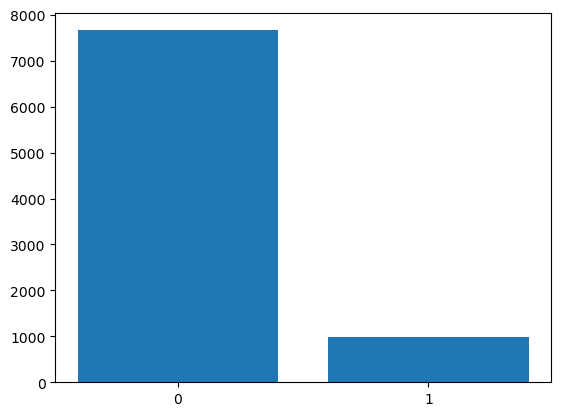

In [30]:
# binary-class
count0, count1 = data[outcome].value_counts()
print(count0, count1)

x = ['0','1']
y = [count0, count1]
plt.bar(x, y)

## 1.3.4. Weight Data

In [32]:
data['w'] = calc_weights(df=data, sens_features_name="MOM_RACE", outcome_name=outcome)

## 1.3.5. Get Dummies and Split

In [34]:
# get dummy variables
data = pd.get_dummies(data)

In [35]:
# split into X and y
X = data.drop([outcome], axis=1)
Y = data[[outcome]]

race = data[['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
             'MOM_RACE_Black or African American',
             'MOM_RACE_Multiracial',
             'MOM_RACE_Other',
             'MOM_RACE_Unknown',
             'MOM_RACE_White',
             'MOM_RACE_Hispanic White']]
strat_df = pd.concat([Y,race],axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.90, test_size=0.10, shuffle=True, stratify=strat_df, random_state=1234) #random_state = 1234
X_test = X_test.drop(['w'], axis=1)

In [36]:
# Split the data into training and validation sets
race = X_train[['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
                'MOM_RACE_Black or African American',
                'MOM_RACE_Multiracial',
                'MOM_RACE_Other',
                'MOM_RACE_Unknown',
                'MOM_RACE_White',
                'MOM_RACE_Hispanic White']]
strat_df = pd.concat([y_train,race],axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.85, test_size=0.15, shuffle=True, stratify=strat_df, random_state=0) #random state_1234
X_val = X_val.drop(['w'], axis=1)

In [37]:
# binary-class
count0_train, count1_train = y_train.value_counts()
print(count0_train, count1_train)

count0_val, count1_val = y_val.value_counts()
print(count0_val, count1_val)

count0_test, count1_test = y_test.value_counts()
print(count0_test, count1_test)

5862 761
1034 135
766 100


# 2. Handle imbalanced data

## 2.2. Simple Under Sampling Majority (PMAD)

In [40]:
rus = RandomUnderSampler(sampling_strategy = "auto", random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
weights_rus = X_train_rus['w']
X_train_rus = X_train_rus.drop(['w'], axis=1)
y_train_rus.value_counts()

EPDS_risk2
0.0           761
1.0           761
Name: count, dtype: int64

# 3. Modeling

In [42]:
# Extract weights and drop from training
weights_train = X_train['w']
X_train = X_train.drop(['w'], axis=1)

In [43]:
races = ['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
         'MOM_RACE_Black or African American',
         'MOM_RACE_Hispanic White',
         'MOM_RACE_Multiracial',
         'MOM_RACE_Other',
         'MOM_RACE_Unknown',
         'MOM_RACE_White'
        ]

orig_results = []
n_trials = 100 # for finetuning

## XG Boost Classifier

### Finetune XG Boost Classifier without Reweighing

In [46]:
x = X_train_rus
y = y_train_rus.values.ravel()

def objective(trial):
    params = {
        "seed":0,
        "verbosity": 0,
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 1, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 10, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 5),
        "subsample": trial.suggest_float("subsample", 1e-3, 1),
        "lambda": trial.suggest_int("lambda", 3, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(x, y, verbose=False)
    predictions = model.predict(X_val)
    predictions_prob = model.predict_proba(X_val)[:,1]
    BA = balanced_accuracy_score(y_val, predictions)
    AUC = roc_auc_score(y_val, predictions_prob)
    return AUC

#optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=0, consider_prior=True, prior_weight=0.5) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=n_trials)

[I 2024-04-29 10:45:56,131] A new study created in memory with name: no-name-e6b1e3c9-a4d2-4e3d-acd3-9b8d7e66b8e4
[I 2024-04-29 10:45:56,281] Trial 0 finished with value: 0.5893366286983308 and parameters: {'n_estimators': 55, 'learning_rate': 0.7257005721594281, 'max_depth': 4, 'subsample': 0.5453382998138999, 'lambda': 44, 'min_child_weight': 65}. Best is trial 0 with value: 0.5893366286983308.
[I 2024-04-29 10:45:56,379] Trial 1 finished with value: 0.5920660505766888 and parameters: {'n_estimators': 44, 'learning_rate': 3.6905577292137615, 'max_depth': 5, 'subsample': 0.3840580773069519, 'lambda': 80, 'min_child_weight': 53}. Best is trial 1 with value: 0.5920660505766888.
[I 2024-04-29 10:45:56,439] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 57, 'learning_rate': 5.039489598671213, 'max_depth': 1, 'subsample': 0.08804217040183916, 'lambda': 4, 'min_child_weight': 84}. Best is trial 1 with value: 0.5920660505766888.
[I 2024-04-29 10:45:56,515] Trial 3 finished

In [47]:
best_xgb = xgb.XGBClassifier(objective='binary:logistic',verbosity=0, seed=0, **study.best_params)
i = -1
orig_XGB = pd.DataFrame(model_eval(model=best_xgb, model_label='XGB', X_train=x, Y_train=y, X_test=X_test, Y_test=y_test, outcome_label=outcome, verbose=True))

Test AUC: 0.634
Test Balanced Accuracy: 0.591
Test F1: 0.249
Test Precision: 0.155
Test Recall: 0.63


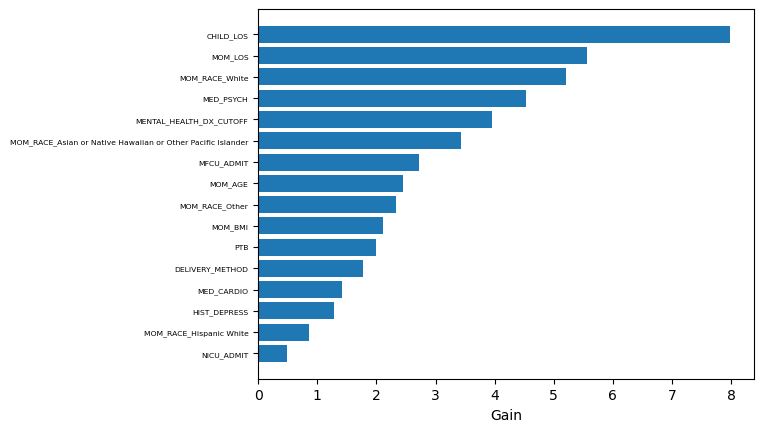

In [48]:
gain = best_xgb.get_booster().get_score(importance_type='gain')
gain_sorted = dict(sorted(gain.items(), key=lambda x: x[1], reverse=False))

features = list(gain_sorted.keys())
values = list(gain_sorted.values())

fig, ax = plt.subplots()
ax.barh(features,values)
plt.yticks(fontsize=5.5)
ax.set_xlabel("Gain")
plt.savefig('EPDS XGB Feature Importance (val).png',dpi=600, bbox_inches='tight')

In [49]:
joblib.dump(best_xgb, 'best_xgb_epds_no_reweigh_val.pkl')

['best_xgb_epds_no_reweigh_val.pkl']

### Finetune XG Boost Classifier with Reweighing

In [51]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

def objective(trial):
    params = {
        "seed":0,
        "verbosity": 0,
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 1, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 10, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 5),
        "subsample": trial.suggest_float("subsample", 1e-3, 1),
        "lambda": trial.suggest_int("lambda", 10, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(x, y, sample_weight=w, verbose=False)
    predictions = model.predict(X_val)
    predictions_prob = model.predict_proba(X_val)[:,1]
    BA = balanced_accuracy_score(y_val, predictions)
    AUC = roc_auc_score(y_val, predictions_prob)
    return AUC

#optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=0, consider_prior=True, prior_weight=0.5) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=n_trials)

[I 2024-04-29 10:46:06,837] A new study created in memory with name: no-name-d0ab3f1b-31fe-4b4e-a1c9-af5cea534d46
[I 2024-04-29 10:46:06,987] Trial 0 finished with value: 0.5883372734436564 and parameters: {'n_estimators': 55, 'learning_rate': 0.7257005721594281, 'max_depth': 4, 'subsample': 0.5453382998138999, 'lambda': 48, 'min_child_weight': 65}. Best is trial 0 with value: 0.5883372734436564.
[I 2024-04-29 10:46:07,056] Trial 1 finished with value: 0.5799842395587076 and parameters: {'n_estimators': 44, 'learning_rate': 3.6905577292137615, 'max_depth': 5, 'subsample': 0.3840580773069519, 'lambda': 82, 'min_child_weight': 53}. Best is trial 0 with value: 0.5883372734436564.
[I 2024-04-29 10:46:07,103] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 57, 'learning_rate': 5.039489598671213, 'max_depth': 1, 'subsample': 0.08804217040183916, 'lambda': 11, 'min_child_weight': 84}. Best is trial 0 with value: 0.5883372734436564.
[I 2024-04-29 10:46:07,168] Trial 3 finishe

In [52]:
best_xgb2 = xgb.XGBClassifier(objective='binary:logistic',verbosity=0, seed=0, **study.best_params)

# original evaluation 
i = -1 # (will output as 0 since iteration = i+1)
orig_XGB2 = pd.DataFrame(model_eval(model=best_xgb2, model_label='XGB', X_train=x, Y_train=y, X_test=X_test, Y_test=y_test, outcome_label=outcome, W=w, verbose=True))

Test AUC: 0.626
Test Balanced Accuracy: 0.574
Test F1: 0.237
Test Precision: 0.151
Test Recall: 0.56


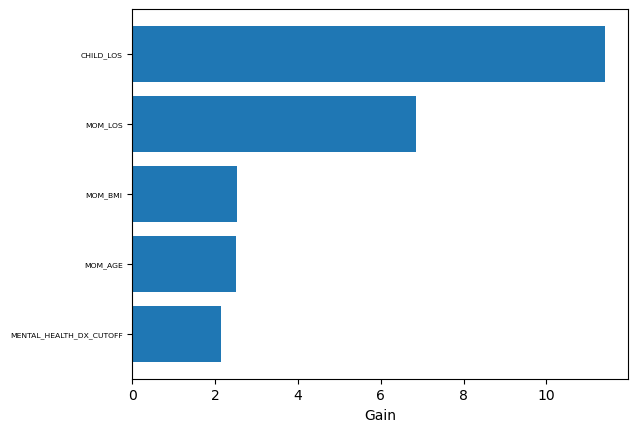

In [53]:
gain = best_xgb2.get_booster().get_score(importance_type='gain')
gain_sorted = dict(sorted(gain.items(), key=lambda x: x[1], reverse=False))

features = list(gain_sorted.keys())
values = list(gain_sorted.values())

fig, ax = plt.subplots()
ax.barh(features,values)
plt.yticks(fontsize=5.5)
ax.set_xlabel("Gain")
plt.savefig('EPDS XGB Feature Importance Reweigh.png',dpi=600, bbox_inches='tight')

In [54]:
joblib.dump(best_xgb2, 'best_xgb_epds_reweigh_val.pkl')

['best_xgb_epds_reweigh_val.pkl']

## Random Forest

### Finetune Random Forest without Reweighing

In [57]:
x = X_train_rus
y = y_train_rus.values.ravel()

def objective(trial):
    params = {'random_state':0,
             'max_features':'sqrt',
             'ccp_alpha': trial.suggest_float("ccp_alpha", 0, 1),
             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
             'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
             'n_estimators': trial.suggest_int('n_estimators', 1, 125),
             'max_depth': trial.suggest_int('max_depth', 1, 5)
             }
    model = RandomForestClassifier(**params)
    model.fit(x, y)
    predictions = model.predict(X_val)
    predictions_prob = model.predict_proba(X_val)[:,1]
    BA = balanced_accuracy_score(y_val, predictions)
    AUC = roc_auc_score(y_val, predictions_prob)
    return AUC

sampler = optuna.samplers.TPESampler(seed=0, consider_prior=True, prior_weight=0.5) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=n_trials)

[I 2024-04-29 10:46:17,476] A new study created in memory with name: no-name-0e2d29cb-6415-4c29-a289-a1e62e8b5bb7
[I 2024-04-29 10:46:17,527] Trial 0 finished with value: 0.5 and parameters: {'ccp_alpha': 0.5488135039273248, 'min_samples_leaf': 36, 'min_samples_split': 31, 'n_estimators': 69, 'max_depth': 3}. Best is trial 0 with value: 0.5.
[I 2024-04-29 10:46:17,607] Trial 1 finished with value: 0.5 and parameters: {'ccp_alpha': 0.6458941130666561, 'min_samples_leaf': 22, 'min_samples_split': 45, 'n_estimators': 121, 'max_depth': 2}. Best is trial 0 with value: 0.5.
[I 2024-04-29 10:46:17,676] Trial 2 finished with value: 0.5 and parameters: {'ccp_alpha': 0.7917250380826646, 'min_samples_leaf': 27, 'min_samples_split': 29, 'n_estimators': 116, 'max_depth': 1}. Best is trial 0 with value: 0.5.
[I 2024-04-29 10:46:17,754] Trial 3 finished with value: 0.5 and parameters: {'ccp_alpha': 0.08712929970154071, 'min_samples_leaf': 2, 'min_samples_split': 42, 'n_estimators': 98, 'max_depth': 5

In [58]:
best_rf = RandomForestClassifier(random_state=0,max_features='sqrt',**study.best_params)

# original evaluation 
i = -1 # (will output as 0 since iteration = i+1)
orig_RF = pd.DataFrame(model_eval(model=best_rf, model_label='RF', X_train=x, Y_train=y, X_test=X_test, Y_test=y_test, outcome_label=outcome, verbose=True))

Test AUC: 0.633
Test Balanced Accuracy: 0.601
Test F1: 0.257
Test Precision: 0.161
Test Recall: 0.63


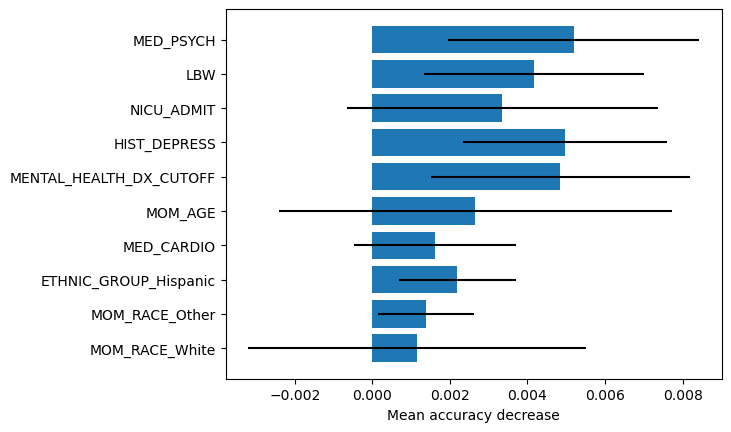

In [59]:
from sklearn.inspection import permutation_importance
imp_result = permutation_importance(
    best_rf, X_test, y_test, n_repeats=10, random_state=2024, n_jobs=2
)

importance_mean = imp_result.importances_mean
importance_sd = imp_result.importances_std

ind = np.argpartition(importance_mean, -10)[-10:]
top_feat = X_test.columns[ind]
top_vals = importance_mean[ind]
top_std = importance_sd[ind]

fig, ax = plt.subplots()
ax.barh(top_feat,top_vals,xerr=top_std)
ax.set_xlabel("Mean accuracy decrease")
plt.savefig('EPDS RF Feature Importance (val).png',dpi=600, bbox_inches='tight')

In [60]:
joblib.dump(best_rf, 'best_rf_epds_no_reweigh_val.pkl')

['best_rf_epds_no_reweigh_val.pkl']

### Finetune Random Forest with Reweighing

In [62]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

def objective(trial):
    params = {'random_state':0,
             'max_features':'sqrt',
             'ccp_alpha': trial.suggest_float("ccp_alpha", 0, 1),
             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
             'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
             'n_estimators': trial.suggest_int('n_estimators', 1, 125),
             'max_depth': trial.suggest_int('max_depth', 1, 5)
             }
    model = RandomForestClassifier(**params)
    model.fit(x, y, sample_weight=w)
    predictions = model.predict(X_val)
    predictions_prob = model.predict_proba(X_val)[:,1]
    BA = balanced_accuracy_score(y_val, predictions)
    AUC = roc_auc_score(y_val, predictions_prob)
    return AUC

sampler = optuna.samplers.TPESampler(seed=0, consider_prior=True, prior_weight=0.5) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=n_trials)

[I 2024-04-29 10:46:27,311] A new study created in memory with name: no-name-1ac8baa3-1495-4275-b34c-c6757eaca539
[I 2024-04-29 10:46:27,360] Trial 0 finished with value: 0.5 and parameters: {'ccp_alpha': 0.5488135039273248, 'min_samples_leaf': 36, 'min_samples_split': 31, 'n_estimators': 69, 'max_depth': 3}. Best is trial 0 with value: 0.5.
[I 2024-04-29 10:46:27,434] Trial 1 finished with value: 0.5 and parameters: {'ccp_alpha': 0.6458941130666561, 'min_samples_leaf': 22, 'min_samples_split': 45, 'n_estimators': 121, 'max_depth': 2}. Best is trial 0 with value: 0.5.
[I 2024-04-29 10:46:27,499] Trial 2 finished with value: 0.5 and parameters: {'ccp_alpha': 0.7917250380826646, 'min_samples_leaf': 27, 'min_samples_split': 29, 'n_estimators': 116, 'max_depth': 1}. Best is trial 0 with value: 0.5.
[I 2024-04-29 10:46:27,577] Trial 3 finished with value: 0.5 and parameters: {'ccp_alpha': 0.08712929970154071, 'min_samples_leaf': 2, 'min_samples_split': 42, 'n_estimators': 98, 'max_depth': 5

In [63]:
best_rf2 = RandomForestClassifier(random_state=0,max_features='sqrt',**study.best_params)

# original evaluation 
i = -1 # (will output as 0 since iteration = i+1)
orig_RF2 = pd.DataFrame(model_eval(model=best_rf2, model_label='RF', X_train=x, Y_train=y, X_test=X_test, Y_test=y_test, outcome_label=outcome, W=w, verbose=True))

Test AUC: 0.63
Test Balanced Accuracy: 0.624
Test F1: 0.275
Test Precision: 0.174
Test Recall: 0.65


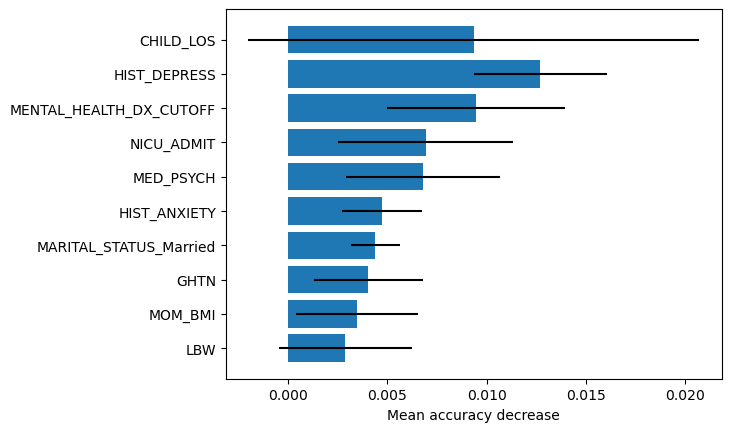

In [64]:
from sklearn.inspection import permutation_importance
imp_result = permutation_importance(
    best_rf2, X_test, y_test, n_repeats=10, random_state=2024, n_jobs=2
)

importance_mean = imp_result.importances_mean
importance_sd = imp_result.importances_std

ind = np.argpartition(importance_mean, -10)[-10:]
top_feat = X_test.columns[ind]
top_vals = importance_mean[ind]
top_std = importance_sd[ind]

fig, ax = plt.subplots()
ax.barh(top_feat,top_vals,xerr=top_std)
ax.set_xlabel("Mean accuracy decrease")
plt.savefig('EPDS RF Feature Importance Reweigh (val).png',dpi=600, bbox_inches='tight')

In [65]:
joblib.dump(best_rf2, 'best_rf_epds_reweigh_val.pkl') 

['best_rf_epds_reweigh_val.pkl']

## Logistic Regression

### Finetune Logistic Regression without Reweighing

In [68]:
x = X_train_rus
y = y_train_rus.values.ravel()

def objective(trial):
    params = {'penalty':'l2',
             'C':trial.suggest_loguniform("C", 1e-2, 1),
             'tol':trial.suggest_uniform('tol' , 1e-6 , 1e-3)
             }
    model = LogisticRegression(**params)
    model.fit(x,y)
    predictions = model.predict(X_val)
    predictions_prob = model.predict_proba(X_val)[:,1]
    BA = balanced_accuracy_score(y_val, predictions)
    AUC = roc_auc_score(y_val, predictions_prob)
    return AUC

sampler = optuna.samplers.TPESampler(seed=0, consider_prior=True, prior_weight=0.5) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=n_trials)

[I 2024-04-29 10:46:35,980] A new study created in memory with name: no-name-ada1d630-f4d9-4c01-84d4-d732bc015bd5
[I 2024-04-29 10:46:36,010] Trial 0 finished with value: 0.6295078444014616 and parameters: {'C': 0.12520653814999466, 'tol': 0.0007154741770060471}. Best is trial 0 with value: 0.6295078444014616.
[I 2024-04-29 10:46:36,041] Trial 1 finished with value: 0.6273372018052868 and parameters: {'C': 0.16051911333587626, 'tol': 0.0005453382998139}. Best is trial 0 with value: 0.6295078444014616.
[I 2024-04-29 10:46:36,071] Trial 2 finished with value: 0.6336700336700336 and parameters: {'C': 0.07035737028722149, 'tol': 0.0006462482189535895}. Best is trial 2 with value: 0.6336700336700336.
[I 2024-04-29 10:46:36,135] Trial 3 finished with value: 0.63391360412637 and parameters: {'C': 0.07501954443620121, 'tol': 0.0008918812277812978}. Best is trial 3 with value: 0.63391360412637.
[I 2024-04-29 10:46:36,155] Trial 4 finished with value: 0.626850060892614 and parameters: {'C': 0.84

In [69]:
best_glm = LogisticRegression(penalty='l2',**study.best_params)

# original evaluation 
i = -1 # (will output as 0 since iteration = i+1)
orig_GLM = pd.DataFrame(model_eval(model=best_glm, model_label='GLM', X_train=x, Y_train=y, X_test=X_test, Y_test=y_test, outcome_label=outcome, verbose=True))

Test AUC: 0.651
Test Balanced Accuracy: 0.612
Test F1: 0.271
Test Precision: 0.178
Test Recall: 0.56


In [70]:
joblib.dump(best_glm, 'best_glm_epds_no_reweigh_val.pkl') 

['best_glm_epds_no_reweigh_val.pkl']

### Finetune Logistic Regression with Reweighing

In [72]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

def objective(trial):
    params = {'penalty':'l2',
             'C':trial.suggest_loguniform("C", 1e-2, 1),
             'tol':trial.suggest_uniform('tol' , 1e-6 , 1e-3)
             }
    model = LogisticRegression(**params)
    model.fit(x, y, sample_weight=w)
    predictions = model.predict(X_val)
    predictions_prob = model.predict_proba(X_val)[:,1]
    BA = balanced_accuracy_score(y_val, predictions)
    AUC = roc_auc_score(y_val, predictions_prob)
    return AUC

sampler = optuna.samplers.TPESampler(seed=0, consider_prior=True, prior_weight=0.5) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=n_trials)

[I 2024-04-29 10:46:41,200] A new study created in memory with name: no-name-446f1d70-671e-4773-b877-306bfbdba25e
[I 2024-04-29 10:46:41,231] Trial 0 finished with value: 0.6135038326527689 and parameters: {'C': 0.12520653814999466, 'tol': 0.0007154741770060471}. Best is trial 0 with value: 0.6135038326527689.
[I 2024-04-29 10:46:41,253] Trial 1 finished with value: 0.6134608496310624 and parameters: {'C': 0.16051911333587626, 'tol': 0.0005453382998139}. Best is trial 0 with value: 0.6135038326527689.
[I 2024-04-29 10:46:41,283] Trial 2 finished with value: 0.6198223368436133 and parameters: {'C': 0.07035737028722149, 'tol': 0.0006462482189535895}. Best is trial 2 with value: 0.6198223368436133.
[I 2024-04-29 10:46:41,313] Trial 3 finished with value: 0.6197077154523962 and parameters: {'C': 0.07501954443620121, 'tol': 0.0008918812277812978}. Best is trial 2 with value: 0.6198223368436133.
[I 2024-04-29 10:46:41,400] Trial 4 finished with value: 0.6089547961888389 and parameters: {'C':

In [73]:
best_glm2 = LogisticRegression(penalty='l2',**study.best_params)

# original evaluation 
i = -1 # (will output as 0 since iteration = i+1)
orig_GLM2 = pd.DataFrame(model_eval(model=best_glm2, model_label='GLM', X_train=x, Y_train=y, X_test=X_test, Y_test=y_test, outcome_label=outcome, W=w, verbose=True))

Test AUC: 0.64
Test Balanced Accuracy: 0.619
Test F1: 0.277
Test Precision: 0.183
Test Recall: 0.57


In [74]:
joblib.dump(best_glm2, 'best_glm_epds_reweigh_val.pkl')

['best_glm_epds_reweigh_val.pkl']

In [75]:
orig_results = pd.concat([orig_XGB,orig_XGB2,orig_RF,orig_RF2,orig_GLM,orig_GLM2],axis=0)
orig_results.to_excel("EPDS_orig_results.xlsx")

# Boostrap Test Results

In [77]:
best_glm = joblib.load('best_glm_phq9_no_reweigh_val.pkl')
best_glm2 = joblib.load('best_glm_phq9_reweigh_val.pkl')

best_rf = joblib.load('best_rf_phq9_no_reweigh_val.pkl')
best_rf2 = joblib.load('best_rf_phq9_reweigh_val.pkl')

best_xgb = joblib.load('best_xgb_phq9_no_reweigh_val.pkl')
best_xgb2 = joblib.load('best_xgb_phq9_reweigh_val.pkl')

In [78]:
boot_test_results = pd.DataFrame()
outcome = 'EPDS_risk2'
for i in range(100):
    test_set_boot = pd.concat([y_test,X_test],axis=1).sample(n=len(X_test), replace=True, random_state=i, ignore_index=True)
    x = test_set_boot.drop([outcome], axis=1)
    y = test_set_boot[outcome]
        
    boot_test_results = pd.concat([boot_test_results,pd.DataFrame(model_eval(model=best_xgb, model_label='XGB', X_train = X_train_rus, Y_train = y_train_rus.values.ravel(), X_test = x, Y_test = y, outcome_label=outcome, verbose=False))],axis=0)
    boot_test_results = pd.concat([boot_test_results,pd.DataFrame(model_eval(model=best_xgb2, model_label='XGB', X_train = X_train_rus, Y_train = y_train_rus.values.ravel(), X_test = x, Y_test = y, outcome_label=outcome, W=weights_rus, verbose=False))],axis=0)
    boot_test_results = pd.concat([boot_test_results,pd.DataFrame(model_eval(model=best_rf, model_label='RF', X_train = X_train_rus, Y_train = y_train_rus.values.ravel(), X_test = x, Y_test = y, outcome_label=outcome, verbose=False))],axis=0)
    boot_test_results = pd.concat([boot_test_results,pd.DataFrame(model_eval(model=best_rf2, model_label='RF', X_train = X_train_rus, Y_train = y_train_rus.values.ravel(), X_test = x, Y_test = y, outcome_label=outcome, W=weights_rus, verbose=False))],axis=0)
    boot_test_results = pd.concat([boot_test_results,pd.DataFrame(model_eval(model=best_glm, model_label='GLM', X_train = X_train_rus, Y_train = y_train_rus.values.ravel(), X_test = x, Y_test = y, outcome_label=outcome, verbose=False))],axis=0)
    boot_test_results = pd.concat([boot_test_results,pd.DataFrame(model_eval(model=best_glm2, model_label='GLM',X_train = X_train_rus, Y_train = y_train_rus.values.ravel(), X_test = x, Y_test = y, outcome_label=outcome, W=weights_rus, verbose=False))],axis=0)

In [79]:
boot_test_results.to_excel("EPDS_boot_test_results.xlsx")

# Evaluate Models Over Many Splits

In [81]:
outcome = 'EPDS_risk2'

# split into X and y
X = data.drop([outcome], axis=1)
Y = data[[outcome]]
repeat_results = pd.DataFrame()

n_repeat = 10
k_fold = 10
for i in range(n_repeat):
    kf = KFold(n_splits=k_fold, random_state=i, shuffle=True)
    for k, (train_index, test_index) in enumerate(kf.split(X)):
        
        x_train = X.iloc[train_index]
        y_train = Y.iloc[train_index]
        
        x_test = X.iloc[test_index]
        x_test = x_test.drop(['w'], axis=1)
        y_test = Y.iloc[test_index]
        
        rus = RandomUnderSampler(sampling_strategy = "auto", random_state=0)
        x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)
        weights_rus = x_train_rus['w']
        x_train_rus = x_train_rus.drop(['w'], axis=1)
        y_train_rus.value_counts()
        
        repeat_results = pd.concat([repeat_results,pd.DataFrame(model_eval(model=best_xgb, model_label='XGB', X_train = x_train_rus, Y_train = y_train_rus, X_test = x_test, Y_test = y_test, outcome_label=outcome, verbose=False))],axis=0)
        repeat_results = pd.concat([repeat_results,pd.DataFrame(model_eval(model=best_xgb2, model_label='XGB', X_train = x_train_rus, Y_train = y_train_rus, X_test = x_test, Y_test = y_test, outcome_label=outcome, W=weights_rus, verbose=False))],axis=0)
        repeat_results = pd.concat([repeat_results,pd.DataFrame(model_eval(model=best_rf, model_label='RF', X_train = x_train_rus, Y_train = y_train_rus, X_test = x_test, Y_test = y_test, outcome_label=outcome, verbose=False))],axis=0)
        repeat_results = pd.concat([repeat_results,pd.DataFrame(model_eval(model=best_rf2, model_label='RF', X_train = x_train_rus, Y_train = y_train_rus, X_test = x_test, Y_test = y_test, outcome_label=outcome, W=weights_rus, verbose=False))],axis=0)
        repeat_results = pd.concat([repeat_results,pd.DataFrame(model_eval(model=best_glm, model_label='GLM', X_train = x_train_rus, Y_train = y_train_rus, X_test = x_test, Y_test = y_test, outcome_label=outcome, verbose=False))],axis=0)
        repeat_results = pd.concat([repeat_results,pd.DataFrame(model_eval(model=best_glm2, model_label='GLM',X_train = x_train_rus, Y_train = y_train_rus, X_test = x_test, Y_test = y_test, outcome_label=outcome, W=weights_rus, verbose=False))],axis=0)
    print("Iteration",i,"complete")

Iteration 0 complete
Iteration 1 complete
Iteration 2 complete
Iteration 3 complete
Iteration 4 complete
Iteration 5 complete
Iteration 6 complete
Iteration 7 complete
Iteration 8 complete
Iteration 9 complete


In [82]:
repeat_results.to_excel("EPDS_repeat_results.xlsx")

In [83]:
# save this file and output as html
import os
os.system('jupyter nbconvert --to html model_finetune_EPDS.ipynb')

[NbConvertApp] Converting notebook model_finetune_EPDS.ipynb to html
[NbConvertApp] Writing 1041336 bytes to model_finetune_EPDS.html


0